In [15]:
# PyMC for Bayesian Inference
import pymc as pm
import arviz as az
import bambi as bmb
print(f"Running on PyMC v{pm.__version__}")

# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Scikit-learn utilities
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Matplotlib and seaborn for visualizations
import matplotlib.pyplot as plt
%matplotlib inline

Running on PyMC v5.10.4


In [16]:
df = pd.read_csv('data/HI_Small_Trans_Standardised.csv')
df.head()

,FromAccount,ToAccount,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,Timestamp,AmountPaid,AmountReceived,IsLaundering
0,6530,6530,8,8,12,12,5,2022-09-01 00:20:00,3697.34,3697.34,0
1,358174,176809,109,0,12,12,3,2022-09-01 00:20:00,0.01,0.01,0
2,358476,358476,110,110,12,12,5,2022-09-01 00:00:00,14675.57,14675.57,0
3,74640,74640,10,10,12,12,5,2022-09-01 00:02:00,2806.97,2806.97,0
4,6538,6538,8,8,12,12,5,2022-09-01 00:06:00,36682.97,36682.97,0


In [17]:
# additional feature pre-processing

# Split Timestamp column into MM, DD, HH etc. (Ignore dt columns with constant values)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
# df['Year'] = df['Timestamp'].dt.year
# df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
# df['Second'] = df['Timestamp'].dt.second
df = df.drop(columns=['Timestamp'])

# Benford's law: Add first leading digit from both "Amount Paid" & "Amount Received" columns
def get_first_digit(figure:float) -> int:
    exception_set = ('0','.','e','-')
    for char in str(figure):
        if char not in exception_set:
            return int(char)

# df['LD Amount Paid'] = df['Amount Paid'].astype(str).str[:1].astype(int)
df['LDAmountPaid'] = df.apply(lambda x: get_first_digit(x['AmountPaid']), axis=1)
# df['LD Amount Received'] = df['Amount Received'].astype(str).str[:1].astype(int)
df['LDAmountReceived'] = df.apply(lambda x: get_first_digit(x['AmountReceived']), axis=1)

df.head()

,FromAccount,ToAccount,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,AmountPaid,AmountReceived,IsLaundering,Day,Hour,Minute,LDAmountPaid,LDAmountReceived
0,6530,6530,8,8,12,12,5,3697.34,3697.34,0,1,0,20,3,3
1,358174,176809,109,0,12,12,3,0.01,0.01,0,1,0,20,1,1
2,358476,358476,110,110,12,12,5,14675.57,14675.57,0,1,0,0,1,1
3,74640,74640,10,10,12,12,5,2806.97,2806.97,0,1,0,2,2,2
4,6538,6538,8,8,12,12,5,36682.97,36682.97,0,1,0,6,3,3


<Axes: ylabel='Frequency'>

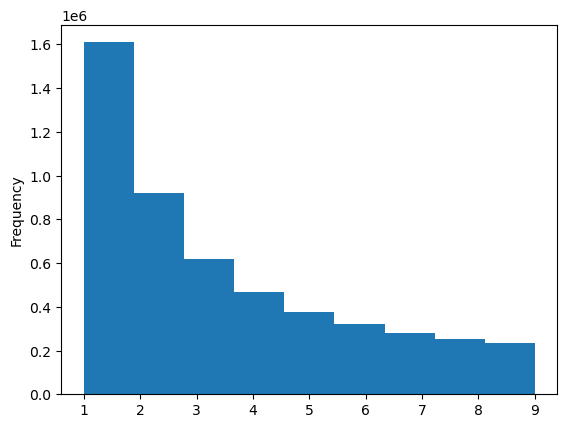

In [18]:
df['LDAmountPaid'].plot.hist(bins=9)

<Axes: ylabel='Frequency'>

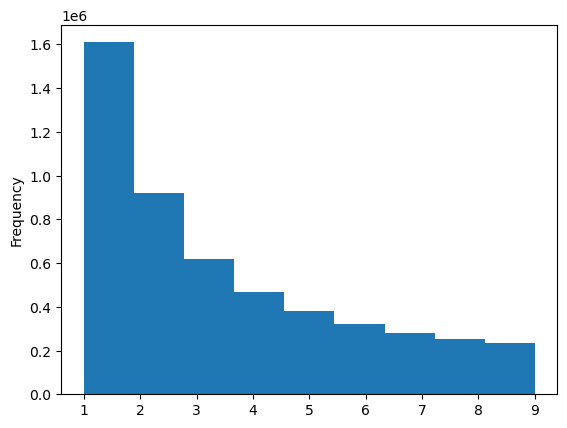

In [19]:
df['LDAmountReceived'].plot.hist(bins=9)

In [20]:
features = df.drop(columns='IsLaundering')
labels = df['IsLaundering']
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [21]:
# undersampling majority class
train_df = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)],axis=1)
class_counts = train_df['IsLaundering'].value_counts()
df_majority = train_df[train_df['IsLaundering'] == 0]
df_minority = train_df[train_df['IsLaundering'] == 1]
df_majority_downsampled = resample(df_majority, replace=False, n_samples=class_counts[1])
df_balanced = pd.concat([df_majority_downsampled, df_minority])
X_train, y_train = df_balanced.iloc[:, :-1], df_balanced.iloc[:, [-1]]

<Axes: ylabel='Frequency'>

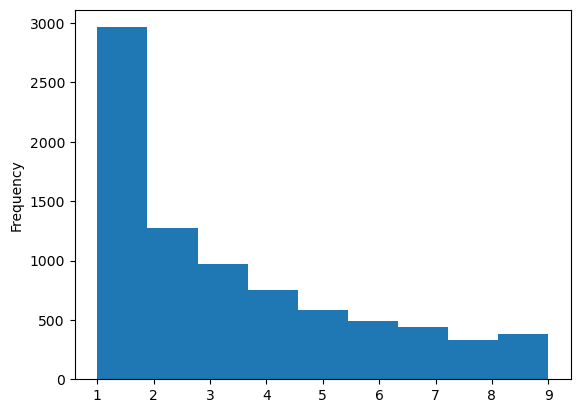

In [22]:
df_balanced['LDAmountReceived'].plot.hist(bins=9)

<Axes: ylabel='Frequency'>

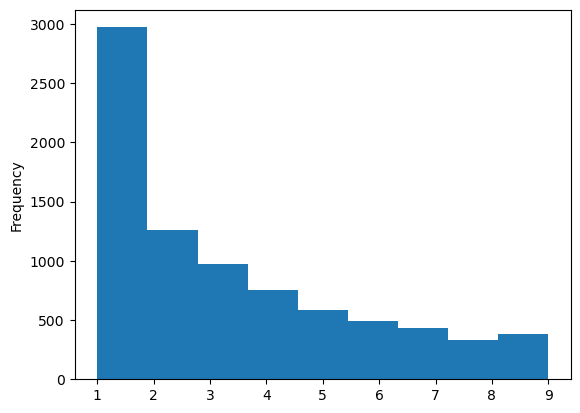

In [23]:
df_balanced['LDAmountPaid'].plot.hist(bins=9)

### Bayesian Logistic Regression

In [24]:
# Build up a formula
formula = [' %s + ' % variable for variable in X_train.columns]
formula.insert(0, 'y ~ ')
formula = ' '.join(''.join(formula).split(' ')[:-2])
formula

'y ~  FromAccount +  ToAccount +  FromBank +  ToBank +  ReceivingCurrency +  PaymentCurrency +  PaymentFormat +  AmountPaid +  AmountReceived +  Day +  Hour +  Minute +  LDAmountPaid +  LDAmountReceived'

In [25]:
# Create version of the training data with labels
X_with_labels = X_train.copy()
X_with_labels['y'] = y_train

In [26]:
X_with_labels.describe()

,FromAccount,ToAccount,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,AmountPaid,AmountReceived,Day,Hour,Minute,LDAmountPaid,LDAmountReceived,y
count,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8.180000e+03,8.180000e+03,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000,8180.000000
mean,238991.993154,209264.096333,1826.487286,2343.374328,8.361125,8.373716,1.750000,2.609051e+07,2.612123e+07,5.779829,11.107579,28.613936,3.228362,3.229951,0.500000
std,164333.570492,144306.442515,3075.309155,2870.304265,4.053126,4.052000,1.868908,1.234480e+09,1.234481e+09,3.379825,6.873380,17.400762,2.452169,2.453441,0.500031
min,38.000000,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e-06,1.000000e-06,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,105264.000000,93318.500000,33.000000,90.000000,4.000000,4.000000,0.000000,6.586925e+02,6.567825e+02,2.000000,5.000000,13.000000,1.000000,1.000000,0.000000
50%,204746.000000,186343.500000,614.000000,778.000000,10.000000,10.000000,1.000000,4.515595e+03,4.531940e+03,6.000000,12.000000,28.000000,2.000000,2.000000,0.500000
75%,345733.250000,289485.000000,973.000000,6033.000000,12.000000,12.000000,3.000000,1.748627e+04,1.755061e+04,8.000000,17.000000,44.000000,5.000000,5.000000,1.000000
max,515053.000000,515086.000000,30149.000000,29385.000000,14.000000,14.000000,6.000000,8.485314e+10,8.485314e+10,18.000000,23.000000,59.000000,9.000000,9.000000,1.000000


In [27]:
# Building of Bayesian Logistic Regression model
model = bmb.Model(formula, X_with_labels, family="bernoulli")
model

       Formula: y ~  FromAccount +  ToAccount +  FromBank +  ToBank +  ReceivingCurrency +  PaymentCurrency +  PaymentFormat +  AmountPaid +  AmountReceived +  Day +  Hour +  Minute +  LDAmountPaid +  LDAmountReceived
        Family: bernoulli
          Link: p = logit
  Observations: 8180
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 13.0745)
            FromAccount ~ Normal(mu: 0.0, sigma: 0.0)
            ToAccount ~ Normal(mu: 0.0, sigma: 0.0)
            FromBank ~ Normal(mu: 0.0, sigma: 0.0008)
            ToBank ~ Normal(mu: 0.0, sigma: 0.0009)
            ReceivingCurrency ~ Normal(mu: 0.0, sigma: 0.6168)
            PaymentCurrency ~ Normal(mu: 0.0, sigma: 0.617)
            PaymentFormat ~ Normal(mu: 0.0, sigma: 1.3378)
            AmountPaid ~ Normal(mu: 0.0, sigma: 0.0)
            AmountReceived ~ Normal(mu: 0.0, sigma: 0.0)
            Day ~ Normal(mu: 0.0, sigma: 0.7397)
            Hour ~ Normal(mu: 0.0, sigm

Sampling: [AmountPaid, AmountReceived, Day, FromAccount, FromBank, Hour, Intercept, LDAmountPaid, LDAmountReceived, Minute, PaymentCurrency, PaymentFormat, ReceivingCurrency, ToAccount, ToBank]


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'FromAccount'}>,
        <Axes: title={'center': 'ToAccount'}>],
       [<Axes: title={'center': 'FromBank'}>,
        <Axes: title={'center': 'ToBank'}>,
        <Axes: title={'center': 'ReceivingCurrency'}>],
       [<Axes: title={'center': 'PaymentCurrency'}>,
        <Axes: title={'center': 'PaymentFormat'}>,
        <Axes: title={'center': 'AmountPaid'}>],
       [<Axes: title={'center': 'AmountReceived'}>,
        <Axes: title={'center': 'Day'}>,
        <Axes: title={'center': 'Hour'}>],
       [<Axes: title={'center': 'Minute'}>,
        <Axes: title={'center': 'LDAmountPaid'}>,
        <Axes: title={'center': 'LDAmountReceived'}>]], dtype=object)

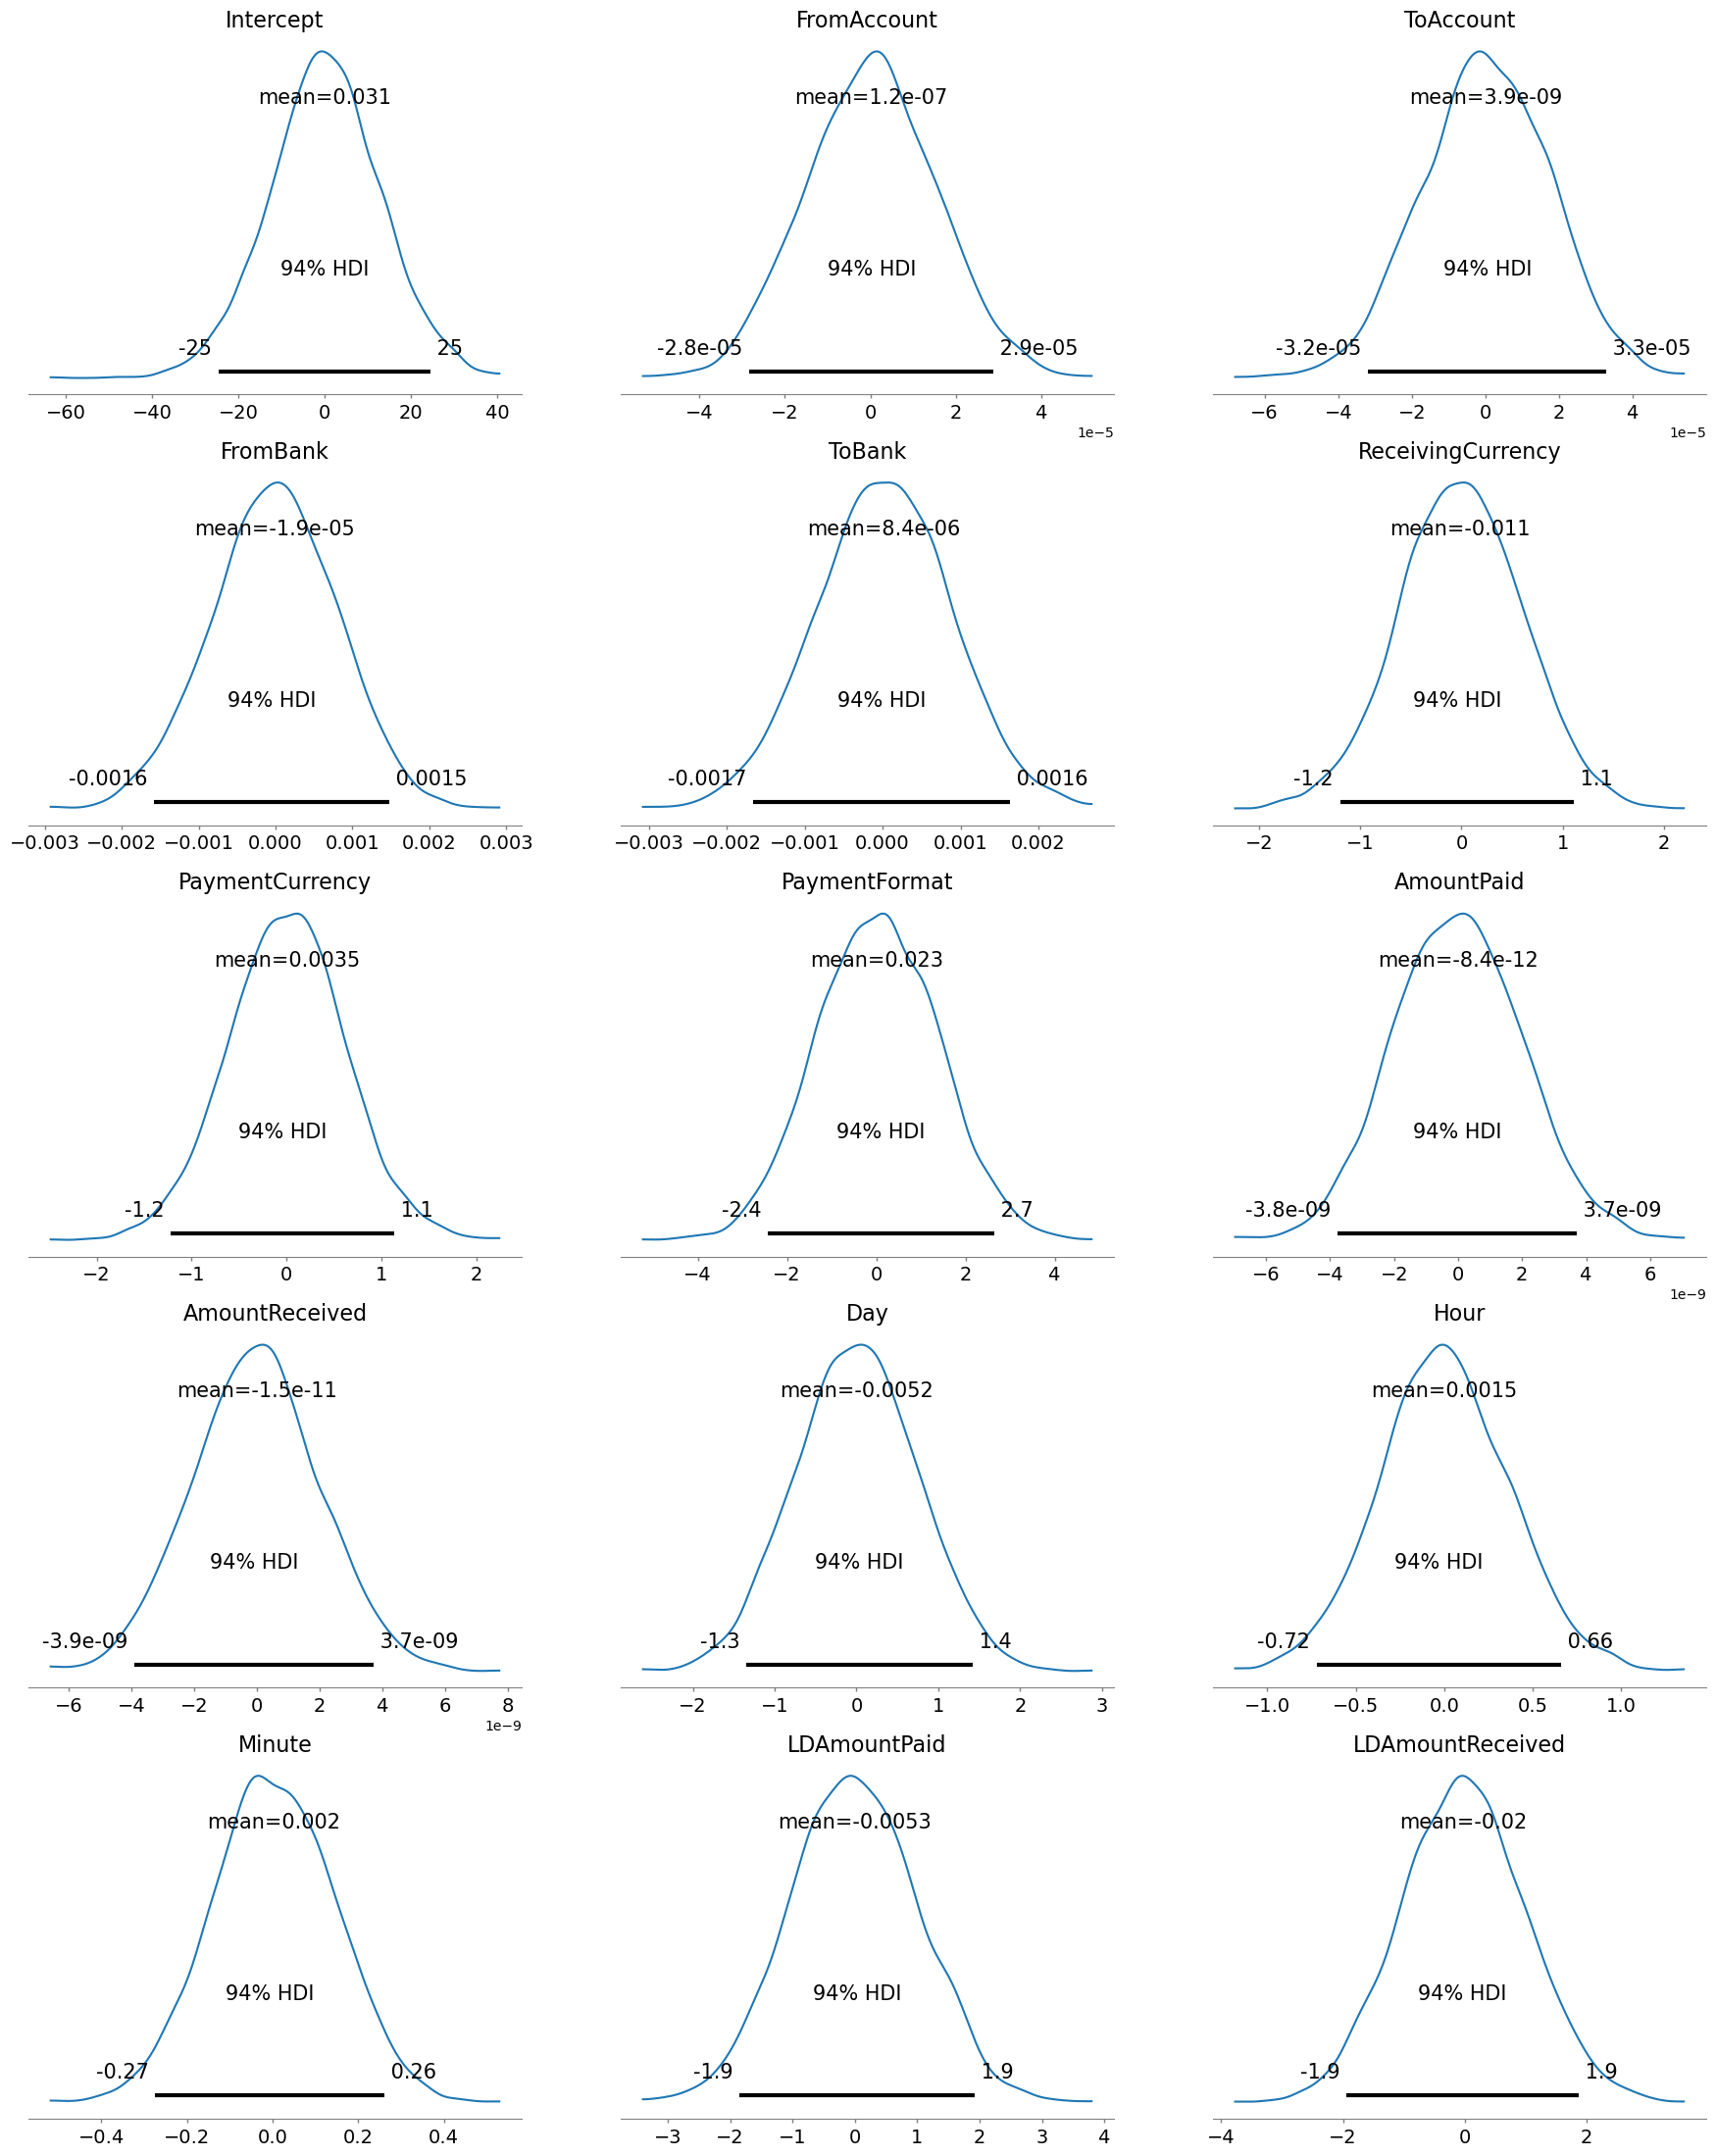

In [28]:
# Plot marginal priors of the built model
model.build()
model.plot_priors()

In [29]:
# fit the model
results = model.fit(draws=1000, chains=2, inference_method='nuts_blackjax')

Modeling the probability that y==1
Compiling...
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
Compilation time = 0:00:01.121232
Sampling...
Sampling time = 0:00:17.015258
Transforming variables...
Transformation time = 0:00:00.103207


In [30]:
results

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'FromAccount'}>,
        <Axes: title={'center': 'FromAccount'}>],
       [<Axes: title={'center': 'ToAccount'}>,
        <Axes: title={'center': 'ToAccount'}>],
       [<Axes: title={'center': 'FromBank'}>,
        <Axes: title={'center': 'FromBank'}>],
       [<Axes: title={'center': 'ToBank'}>,
        <Axes: title={'center': 'ToBank'}>],
       [<Axes: title={'center': 'ReceivingCurrency'}>,
        <Axes: title={'center': 'ReceivingCurrency'}>],
       [<Axes: title={'center': 'PaymentCurrency'}>,
        <Axes: title={'center': 'PaymentCurrency'}>],
       [<Axes: title={'center': 'PaymentFormat'}>,
        <Axes: title={'center': 'PaymentFormat'}>],
       [<Axes: title={'center': 'AmountPaid'}>,
        <Axes: title={'center': 'AmountPaid'}>],
       [<Axes: title={'center': 'AmountReceived'}>,
        <Axes: title={'center': 'AmountReceived'}>],
      

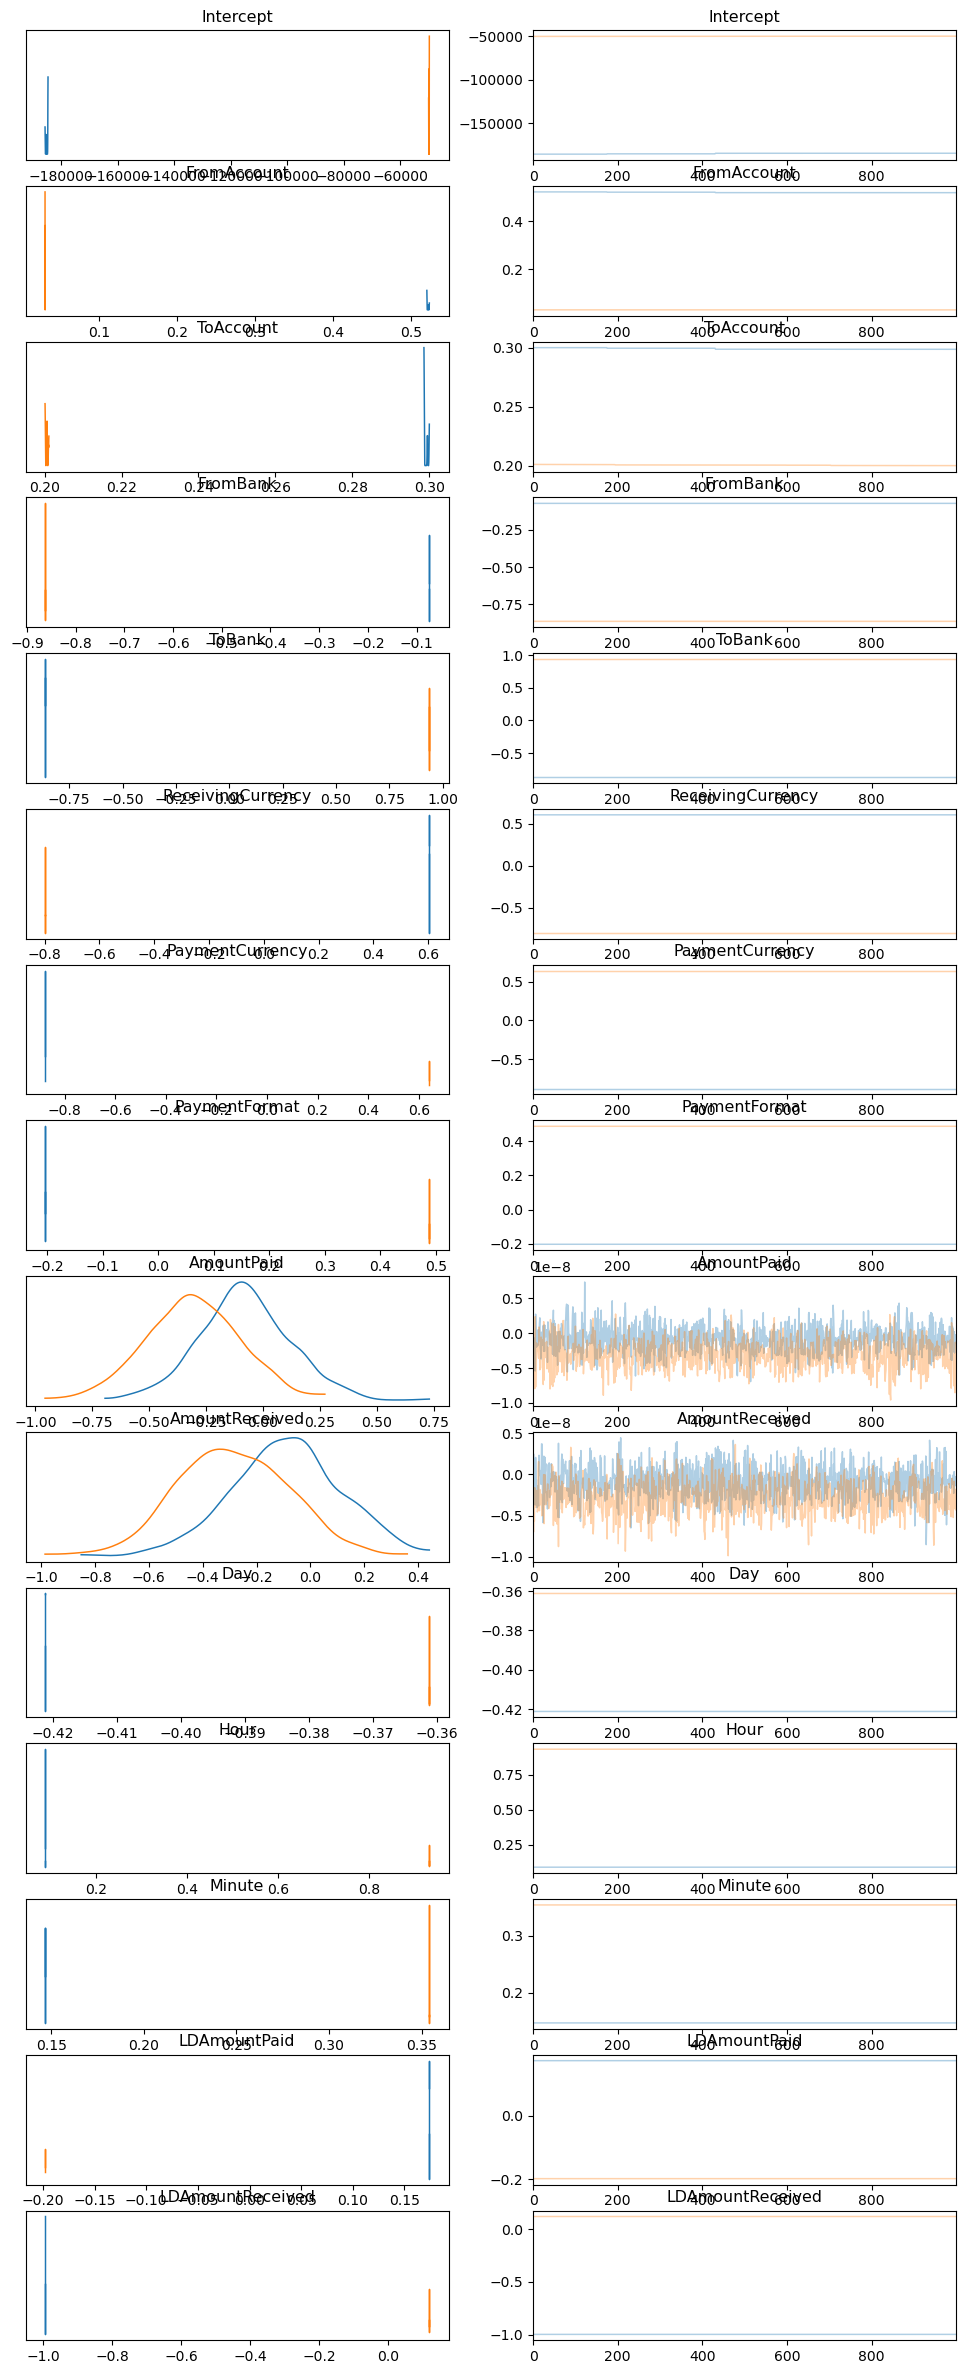

In [31]:
# traceplots and density estimates for the posteriors
az.plot_trace(results, compact=False)

In [32]:
# summary of the posteriors
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-117444.651,67558.173,-185672.482,-49800.424,47579.267,40249.856,2.0,11.0,3.04
FromAccount,0.276,0.245,0.030,0.523,0.173,0.146,2.0,11.0,3.04
ToAccount,0.250,0.049,0.200,0.300,0.035,0.029,2.0,11.0,3.04
FromBank,-0.468,0.395,-0.863,-0.074,0.278,0.235,2.0,18.0,2.40
ToBank,0.037,0.901,-0.864,0.937,0.634,0.537,3.0,13.0,2.29
ReceivingCurrency,-0.097,0.701,-0.798,0.604,0.494,0.418,3.0,11.0,1.87
PaymentCurrency,-0.118,0.760,-0.877,0.642,0.535,0.453,2.0,22.0,2.37
PaymentFormat,0.142,0.346,-0.204,0.488,0.244,0.206,3.0,21.0,2.02
AmountPaid,-0.000,0.000,-0.000,0.000,0.000,0.000,7.0,288.0,1.19
AmountReceived,-0.000,0.000,-0.000,0.000,0.000,0.000,10.0,124.0,1.15
